In [2]:
import numpy as np
import sympy as sp
import scipy
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
# from itertools import combinations
import warnings
import pickle
import threading
warnings.filterwarnings("ignore")

$r_{ij} = r_i - r_j$
$$
U(r_{ij}) = 4\varepsilon [(\sigma/r_{ij})^{12} - (\sigma/r_{ij})^6] \\
U^*(r_{ij}) = 4[(r_{ij}^*)^{-12} - (r_{ij}^*)^{-6}] \\
\phantom{U^*(r_{ij})} = 4[(r_{ij}^*)^{-6} - 1](r_{ij}^*)^{-6} \\
$$
Force atom $j$ exerts on $i$
$$
\vec{F}^*(r_{ij}) = 48[(r_{ij}^*)^{-6} - 0.5](r_{ij}^*)^{-8} \vec{r_{ij}^*} \\
$$

[19.74111019 15.9565494 ]
(2, 210)
210


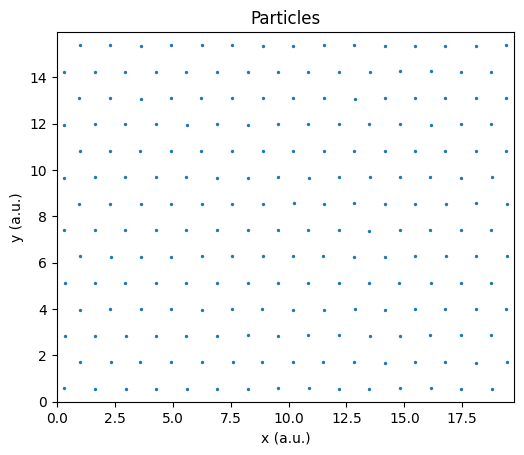

In [113]:
# SET UP RANDOM INITIAL CONDITIONS
rng = np.random.default_rng(seed=102)

X_U_MIN = 2**(1/6)*1
N_L = 15
# N = N_L*N_L
DIM = 2

DENSITY = 0.5
RANDOM_DISPLACEMENT = 0.02

def generate_square_lattice(den,n):
    step = (1 / den) ** .5
    # generate matrices of lattice coordinates
    rmat = np.array(np.meshgrid(np.arange(0,n),np.arange(0,n)),dtype=float)
    rmat += 1/2
    rmat *= step
    # convert matrices of x and y positions to vectors of x and y positions, and return
    l_wrap = n*step, n*step
    r = np.vstack(list(map(np.concatenate,rmat)))
    N = len(r[0])
    return r, l_wrap, N

def generate_triangular_lattice(den,n):
    step = (np.sqrt(3)/2 / den) ** .5
    # generate matrices of lattice coordinates
    n += (n+1)%2
    rmat = np.array(np.meshgrid(np.arange(0,n),np.arange(0,n-1)),dtype=float)
    rmat[0] += 1/4
    rmat[1] += 1/2
    rmat[0][1::2] += 1/2
    rmat[0] *= step
    rmat[1] *= step * np.sqrt(3)/2
    # convert matrices of x and y positions to vectors of x and y positions, and return
    l_wrap = n*step, (n-1)*step * np.sqrt(3)/2
    r = np.vstack(list(map(np.concatenate,rmat)))
    N = len(r[0])
    L = max(l_wrap)
    s_wrap = l_wrap / L
    r /= L
    return r, L, s_wrap, N

# generate lattice positions
r,L,wrap,N = generate_triangular_lattice(DENSITY,N_L)
wrap = np.array(wrap)
print(wrap*L)
# add small random displacements
r += rng.uniform(-RANDOM_DISPLACEMENT,RANDOM_DISPLACEMENT,r.shape)/L
print(r.shape)
print(N)

T_i = 0.5
v = rng.normal(0, T_i**0.5, (DIM,N))

r0,v0 = r,v

plt.title("Particles")
plt.xlim(0, wrap[0]*L)
plt.ylim(0, wrap[1]*L)
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.gca().set_aspect('equal')
plt.scatter(*r*L, s=2)
plt.show()

R_CUTOFF: 2.5
U_CUTOFF: -0.016316891136
testing with r as [xs, ys]
[[1. 2. 3.]
 [2. 3. 4.]]
[ 5. 13. 25.]
[-0.01542711  0.          0.        ]
[[0.0377856 0.        0.       ]
 [0.0755712 0.        0.       ]]

testing with r as [x matrix, y matrix]
[[ 5. 10. 17.]
 [ 8. 13. 20.]
 [13. 18. 25.]]
[[-0.01542711  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[[0.0377856 0.        0.       ]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]

 [[0.0755712 0.        0.       ]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]]


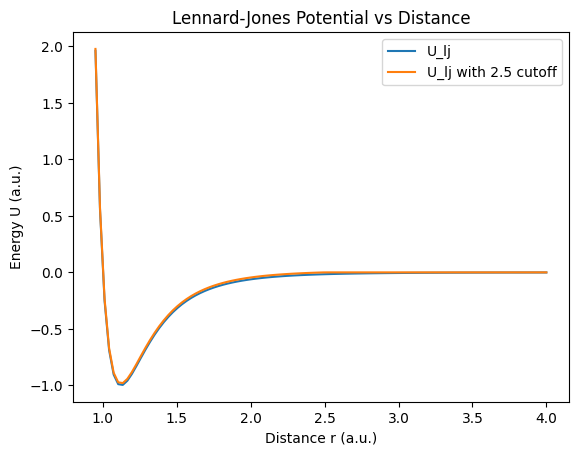

In [114]:
def magnitude2(x):
    return (x*x).sum(axis=0)

def pair_U_lj(x):
    return 4*(x**-6 - 1)*x**-6

# R_CUTOFF = L.min()/2
R_CUTOFF = 2.5
R_CUTOFF2 = R_CUTOFF**2
U_CUTOFF = pair_U_lj(R_CUTOFF)
print(f"R_CUTOFF: {R_CUTOFF}")
print(f"U_CUTOFF: {U_CUTOFF}")

def pair_U_lj_vec(r):
    r2 = magnitude2(r)
    return (r2<R_CUTOFF2) * (4*(r2**-3 - 1)*r2**-3 - U_CUTOFF)
    # return 4*(r2**-3 - 1)*r2**-3 - U_CUTOFF

def pair_F_lj_vec(r):
    r2 = magnitude2(r)
    return (r2<R_CUTOFF2) * (-48*(r2**-3 - 0.5)*r2**-4 * r)

print("testing with r as [xs, ys]")
rtest = np.array([[1,2,3],[2,3,4]], dtype=float)
print(rtest)
print(magnitude2(rtest))
print(pair_U_lj_vec(rtest))
print(pair_F_lj_vec(rtest))

print()
print("testing with r as [x matrix, y matrix]")
rmat = np.array([
    [[1,1,1],[2,2,2],[3,3,3]],
    [[2,3,4],[2,3,4],[2,3,4]],
], dtype=float)
print(magnitude2(rmat))
print(pair_U_lj_vec(rmat))
print(pair_F_lj_vec(rmat))

x = np.linspace(0.95,4,100)
plt.plot(x,pair_U_lj(x), label="U_lj")
plt.plot(x,pair_U_lj_vec(np.array([x,[0]*100])), label="U_lj with 2.5 cutoff")

plt.title("Lennard-Jones Potential vs Distance")
plt.xlabel("Distance r (a.u.)")
plt.ylabel("Energy U (a.u.)")
plt.legend()
plt.show()


(2, 210, 210)
L_i 19.741110194287387
L_f 16.640634468116602
(2, 210, 210)
(2, 210)


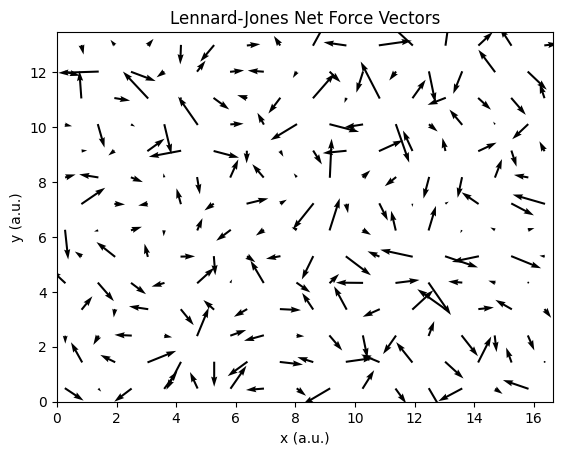

In [115]:
x = r[0]
def pair_displacements_1D(x):
    return -np.diff(np.meshgrid(x,x),axis=0)[0]

def pair_displacements(r): # scuffed implmentation, will change later?
    return np.array([
        (wrap[i]*L/2+pair_displacements_1D(x))%(wrap[i]*L)-wrap[i]*L/2
        for i,x in enumerate(r)
    ])

def magnitudes(v):
    return np.sqrt(np.sum(v**2,axis=0))

def pair_distances(r):
    return magnitudes(pair_displacements(r))

displacements = pair_displacements(r*L)/L
print(displacements.shape)

diag_mask = np.identity(N,dtype=int)==1

def calc_U_av(l):
    Us = pair_U_lj_vec(displacements*l)
    Us[diag_mask] = 0
    Us = Us.sum()
    return Us / N

print("L_i",L)
U_av1 = calc_U_av(L)
while 1:
    U_av2 = calc_U_av(L*0.99)
    if U_av2 > U_av1: break
    L *= 0.99
    U_av1 = U_av2
print("L_f",L)

F = pair_F_lj_vec(displacements*L)
F[:,diag_mask] = 0
print(F.shape)
F_net = F.sum(axis=2)
print(F_net.shape)

# plt.quiver(np.repeat(r[0],N),np.repeat(r[1],N), displacements[0,:,:].ravel(),displacements[1,:,:].ravel(), angles="xy", scale=1, scale_units="xy")
def plot_each_arrow(r,A,color=None):
    if color is None: color=np.ones(len(A[0])**2)
    return plt.quiver(
        *[np.repeat(x,N)for x in r],
        *[A[i,:,:].ravel() for i in range(DIM)],
        color,
        angles="xy", scale=1, scale_units="xy")
# plot_each_arrow(r,lj_forces,magnitudes(lj_forces))
# plt.show()

# plt.title("Displacement Vectors")
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(r,displacements,magnitudes(displacements))
# plt.show()

# plt.title("Lennard-Jones Force Vectors")
# plt.xlim(0, L)
# plt.ylim(0, L)
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(
#     r,
#     lj_forces / magnitudes(lj_forces),
#     np.clip(magnitudes(lj_forces),0,1),
# )
# plt.colorbar()
# plt.text(L*0.1,L*0.1, "Forces are clipped with upper bound 1")
# plt.show()

plt.title("Lennard-Jones Net Force Vectors")
plt.xlim(0, wrap[0]*L)
plt.ylim(0, wrap[1]*L)
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.quiver(*r*L, *F_net, angles="xy", )
plt.show()

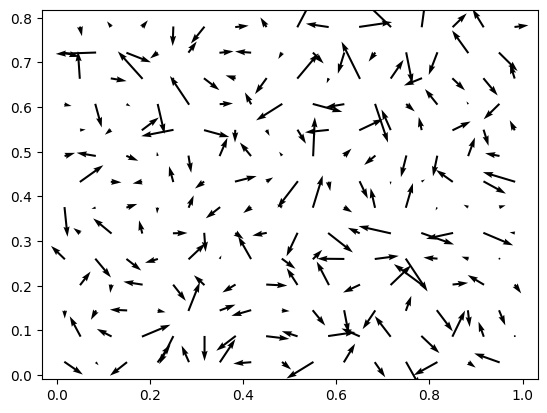

In [183]:
class System():
    def __init__(self, r0, v0, wrap, L, dim, N, steps, dt, T_target=None, zeta=None, Q=None):
        self.N = N
        self.dt = dt
        self.dim = dim

        self.rs = np.zeros((steps, dim, N))
        self.rs[0] = r0
        self.vs = np.zeros((steps, dim, N))
        self.vs[0] = v0
        self.wrap = wrap
        self.L = L
        self.V = np.prod(wrap*self.L)

        # self.displacements = System.pair_displacements(self.rs[0])
        # self.Fs = np.zeros((steps, dim, N))
        # self.calc_F(0)
        self.displacements = self.pair_displacements(self.rs[0]*self.L)/self.L
        self.calc_neighbours(0)
        self.calc_neigh_displacements(0)
        self.Fs = np.zeros((steps, dim, N))
        self.calc_neigh_F(0)

        # self.KEs = np.zeros(steps)
        # self.Ts = np.zeros(steps)
        self.Us = np.zeros(steps)
        # self.Ps = np.zeros(steps)
        self.take_measurements(0)

        # self.nu = 0.2 / dt
        # self.T_ts = -np.log(rng.uniform(size=N))/self.nu
        # self.T_collisions = 0
        if T_target is None:
            self.T_target = 0.5
        else:
            self.T_target = T_target

        self.zeta = 0
        if zeta is not None:
            self.zeta = zeta
        if Q is None:
            self.Q = 2
        else:
            self.Q = Q
        # self.epsilon = np.zeros(steps)

    def step_state(self, i):
        # self.velocity_verlet(i)
        self.nose_hoover(i)
        
        # periodic boundary wrap
        self.rs[i+1] = (self.rs[i+1].T % self.wrap.T).T
        
        # self.a_thermostat(i, self.T_target)
        # thermostat not working?

        self.take_measurements(i+1)


    def calc_neigh_displacements(self,i):
        self.neigh_displacements = [
            ((self.wrap.T/2+(self.rs[i,:,ns]-self.rs[i,:,j]))%self.wrap.T-self.wrap.T/2).T
            for j,ns in enumerate(self.neighbours)
        ] # N x dim x len(ns)

    def calc_neigh_F(self,i):      
        self.Fs[i] = np.array([
            pair_F_lj_vec(np.array(r)*self.L).sum(axis=1)
            for r in self.neigh_displacements
        ]).T

    def calc_neigh_U(self,i):
        U = np.array([
            pair_U_lj_vec(np.array(r)*self.L).sum()
            for r in self.neigh_displacements
        ]).T
        self.Us[i] = U.sum() / self.N

    def calc_neighbours(self,i):
        skin = 0.35
        rv2 = (R_CUTOFF+skin)**2
        self.neighbours = [
            [n for n in range(N)
             if 0 < magnitude2(self.displacements[:,m,n]*self.L) < rv2]
            for m in range(self.N)
        ]
        self.drv = skin
        # self.neigh_t = (skin/(magnitude2(self.vs[i])).max()**.5)

    # def a_thermostat(self, i, T):
    #     if T != None:
    #         self.T_ts -= self.dt
    #         ma = self.T_ts < 0
    #         # ma = self.T_ts == self.T_ts #extreme test: always set temperature
    #         # if i%100==0: print(ma.sum(),end=' ')
    #         for j in range(self.dim):
    #             self.vs[i,j,ma] = rng.normal(0, T**0.5, ma.sum())
    #         self.T_ts[ma] = -np.log(rng.uniform(size=ma.sum()))/self.nu

    def take_measurements(self,i):
        # self.calc_U(i)
        self.calc_neigh_U(i)
        # self.KEs[i] = (self.vs[i]**2).sum() / self.N / 2
        # self.Ts[i] = self.KEs[i] * 2 / self.dim
        # vir = (self.rs[i]*self.L * self.Fs[i]).sum()
        # self.Ps[i] = (self.N * self.Ts[i] + vir/self.dim) / self.V

    @property
    def KEs(self):
        return (self.vs**2).sum(axis=(1,2)) / self.N / 2

    @property
    def Ts(self):
        return self.KEs * 2 / self.dim

    @property
    def Ps(self):
        vir = (self.rs*self.L * self.Fs).sum(axis=(1,2))
        return (self.N * self.Ts + vir/self.dim) / self.V

    # def velocity_verlet(self, i):
    #     dt = self.dt
    #     self.rs[i+1] = self.rs[i] + (self.vs[i]*dt + self.Fs[i] * (dt**2/2))/self.L
    #     # self.displacements = System.pair_displacements(self.rs[i+1])
    #     # self.calc_F(i+1)

    #     self.calc_neigh_displ_and_F(i)
    #     # self.drv -= dt * magnitude2(self.vs[i]).max()**.5
    #     # if self.drv < 0:
    #     #     self.displacements = self.pair_displacements(self.rs[i+1]*self.L)/self.L
    #     #     self.calc_neighbours(i+1)
    #     # self.calc_neigh_displacements(i+1)
    #     # self.calc_neigh_F(i+1)

    #     self.vs[i+1] = self.vs[i] + (self.Fs[i]+self.Fs[i+1])*(dt/2)
    
    # def npt(self, i):
    #     dt = self.dt

    #     Gzeta = ((self.vs[i]**2).sum()+W*(self.vepsilon[i])**2-(2*N+1)*self.T_target)/self.Q
    #     Fepsilon = 2*self.V * (self.)

    #     self.rs[i+1] = np.exp(self.epsilon[i+1]-self.epsilon[i]) * (self.rs[i]*self.L + self.vs[i]*dt + (self.Fs[i]-self.vs[i]*self.vzeta[i] - (2+1/self.N)*self.vs[i]*self.vepsilon[i]) * dt**2/2)/self.L

    #     self.zeta[i+1] = self.zeta[i] + self.vzeta[i]*dt + Gzeta*(dt**2/2)
    #     self.epsilon[i+1] = self.epsilon[i] + self.vepsilon[i]*dt + (self.Fepsilon[i]/self.W-self.vepsilon[i]*self.vzeta[i])*(dt**2/2)

    #     v_2 = self.vs[i] + (self.Fs[i]-self.zeta[i]*self.vs[i]) * (dt/2)

    #     self.calc_neigh_displ_and_F(i)

    #     zeta_2 = self.zeta[i] + ((self.vs[i]**2).sum()/2 - (self.dim*self.N+1)/2 * self.T_target) * (dt/2/self.Q)
    #     self.zeta[i+1] = zeta_2 + ((v_2**2).sum()/2 - (self.dim*self.N+1)/2 * self.T_target) * (dt/2/self.Q)

    #     self.vs[i+1] = (v_2 + self.Fs[i+1]*(dt/2))/(1+self.zeta[i+1]*(dt/2))
            
    def nose_hoover(self, i):
        dt = self.dt
        self.rs[i+1] = self.rs[i] + (self.vs[i]*dt + (self.Fs[i]-self.zeta*self.vs[i]) * dt**2/2)/self.L

        v_2 = self.vs[i] + (self.Fs[i]-self.zeta*self.vs[i]) * (dt/2)

        self.calc_neigh_displ_and_F(i)

        zeta_2 = self.zeta + ((self.vs[i]**2).sum()/2 - (self.dim*self.N+1)/2 * self.T_target) * (dt/2/self.Q)
        self.zeta = zeta_2 + ((v_2**2).sum()/2 - (self.dim*self.N+1)/2 * self.T_target) * (dt/2/self.Q)

        self.vs[i+1] = (v_2 + self.Fs[i+1]*(dt/2))/(1+self.zeta*(dt/2))

    def calc_neigh_displ_and_F(self,i):
        self.drv -= dt * magnitude2(self.vs[i]).max()**.5
        if self.drv < 0:
            self.displacements = self.pair_displacements(self.rs[i+1]*self.L)/self.L
            self.calc_neighbours(i+1)
        self.calc_neigh_displacements(i+1)
        self.calc_neigh_F(i+1)

    # def calc_F(self,i):
    #     lj_forces = pair_F_lj_vec(self.displacements*L)
    #     for j in range(self.dim):
    #         np.fill_diagonal(lj_forces[j,:],0)
    #     self.Fs[i] = lj_forces.sum(axis=2)

    # def calc_U(self,i):
    #     U = pair_U_lj_vec(self.displacements*L)
    #     np.fill_diagonal(U,0)
    #     self.Us[i] = U.sum() / self.N

    @staticmethod
    def pair_displacements_1D(x):
        return -np.diff(np.meshgrid(x,x),axis=0)[0]

    def pair_displacements(self,r):
        return np.array([
            (wrap[i]/2+System.pair_displacements_1D(x)/self.L)%wrap[i]-wrap[i]/2
            for i,x in enumerate(r)
        ])*self.L

t_total,dt = 10,0.001
steps = int(t_total//dt)
test = System(r,v,wrap,L,DIM,N,steps,dt, T_target=0.5)
plt.quiver(*test.rs[0],*test.Fs[0],angles="xy")
# print(L)
# print(test.neigh_displacements[0])
# print(len(test.neigh_displacements),test.neigh_displacements[0].shape)
# print( pair_F_lj_vec(test.neigh_displacements[0]))

In [72]:
with open("systems.pkl","rb") as systems_pickle:
    system_saves = pickle.load(systems_pickle)
print(system_saves)
# system = system_saves[0]
system_saves = []

In [117]:
def time_evolution(r,v,wrap,L,dim,N,steps,dt, T_target, zeta=None, Q=None):
    system = System(r,v,wrap,L,dim,N,steps, dt, T_target=T_target,zeta=zeta, Q=Q)
    for i in range(steps-1):
        system.step_state(i)
    return system

In [184]:
t_total,dt = 3,0.001
steps = int(t_total//dt)
T_target = 0.5
system = time_evolution(r,v,wrap,L,DIM,N,steps,dt, T_target=T_target, zeta=None, Q=0.2)
system_saves = [system]
# print(system_saves)

In [167]:
t_total,dt = 20,0.001
steps = int(t_total//dt)
T_target = 0.5
save = 0
system = time_evolution(
    system_saves[save].rs[-1], system_saves[save].vs[-1],
    wrap,L,DIM,N,steps,dt, T_target=T_target, zeta=system_saves[save].zeta, Q=5
)
# system_saves.append(system)

In [231]:
system = system_saves[0]
# system_saves.append(system)

rs = system.rs; vs = system.vs
t = np.arange(steps)*dt
KEs = system.KEs
Us = system.Us
Ps = system.Ps

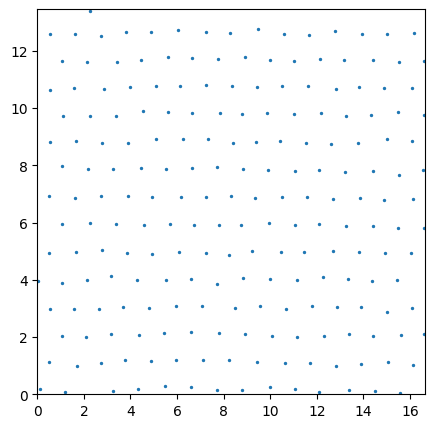

In [208]:
def animate_system(system, out):
    rs = system.rs
    steps = rs.shape[0]
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    points = ax.scatter(*rs[0]*L,s=2)

    fps = 30
    t_anim = 10
    k = steps//(fps*t_anim) # inverse frame density
    nframes = steps // k

    ax.set_xlim(0, wrap[0]*L)
    ax.set_ylim(0, wrap[1]*L)
    def animation_frame(i):
        points.set_offsets(rs[i*k].T*L)

    lj_anim = animation.FuncAnimation(fig, animation_frame, frames=nframes)
    lj_anim.save(out, writer="pillow", fps=fps, dpi=100)
animate_system(system, "test.gif")

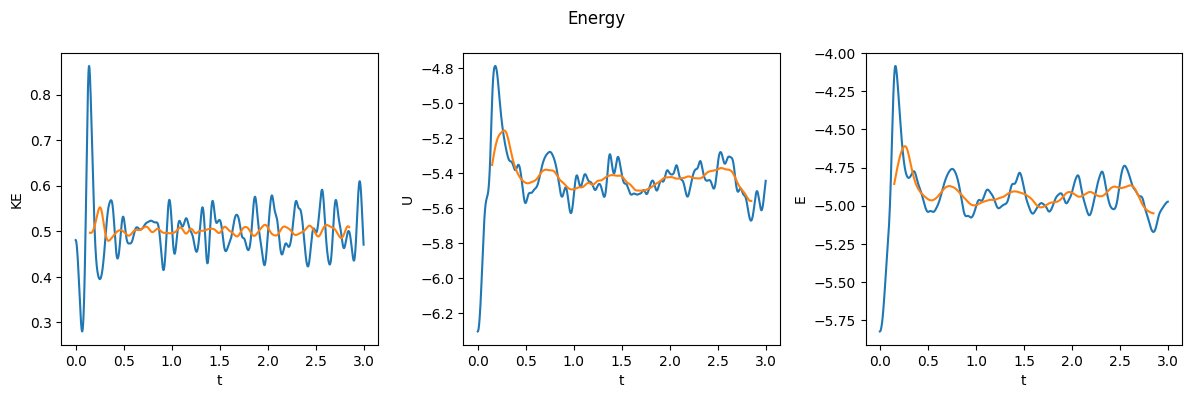

In [186]:
def window(size):
    return np.ones(size)/float(size)
WLEN = steps//10

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

KEs_win = np.convolve(KEs, window(WLEN),'same')[WLEN//2:-WLEN//2]
ax1.plot(t,KEs)
ax1.plot(t[WLEN//2:-WLEN//2], KEs_win)
ax1.set_ylabel("KE")
ax1.set_xlabel("t")

Us_win = np.convolve(Us, window(WLEN),'same')[WLEN//2:-WLEN//2]
ax2.plot(t,Us)
ax2.plot(t[WLEN//2:-WLEN//2], Us_win)
ax2.set_ylabel("U")
ax2.set_xlabel("t")

Es = KEs + Us
Es_win = KEs_win + Us_win
ax3.plot(t,Es)
ax3.plot(t[WLEN//2:-WLEN//2], Es_win)
ax3.set_ylabel("E")
ax3.set_xlabel("t")

fig.suptitle("Energy")
fig.subplots_adjust(top=0.90)
fig.set_size_inches(12,4)
fig.tight_layout(pad=1)
fig.show()

In [ ]:
v2s = vs**2
T = v2s.mean()

v2s_means = v2s.sum(axis=1).mean(axis=1)
v2s_win = np.convolve(v2s_means, window(WLEN),'same')[WLEN//2:-WLEN//2]

plt.plot(t,v2s_means)
plt.plot(t[WLEN//2:-WLEN//2],v2s_win)
plt.show()

T_WIN = WLEN*6
v2s = v2s[-T_WIN-1:-1]

print("T:", T, "T_target:", T_target)
# D = lambda v: (2*np.pi*T)**(-3/2) * 4*np.pi*v**2 * np.exp(-v**2/(2*T))
D = lambda v: (1/T) * v * np.exp(-v**2/(2*T))
D_target = lambda v: (1/T_target) * v * np.exp(-v**2/(2*T_target))

v_abs = np.sqrt(v2s.sum(axis=1))
v_abs = np.concatenate(v_abs)
v_range = np.linspace(0,v_abs.max(),1000)

fig, ax = plt.subplots()
# ax.hist(v_abs)
counts, bins = np.histogram(v_abs, bins=100)
ax.stairs(counts/T_WIN, bins, fill=True)
ax.plot(v_range, D(v_range)*N * (bins[1]-bins[0]), label="measured")
ax.plot(v_range, D_target(v_range)*N * (bins[1]-bins[0]), label="target")
ax.legend()
fig.show()

vx = np.concatenate(vs[:,0,:])
vy = np.concatenate(vs[:,1,:])
v_range = np.linspace(-v_abs.max(),v_abs.max(),1000)
fig2, ax2 = plt.subplots()
counts_x, bins_x = np.histogram(vx, bins=100)
counts_y, bins_y = np.histogram(vy, bins=100)
ax2.stairs(counts_x/T_WIN, bins_x, fill=True)
ax2.stairs(counts_y/T_WIN, bins_y, fill=True)
ax2.plot(v_range,scipy.stats.norm.pdf(v_range,loc=0, scale=T**0.5)*N* (bins_x[1]-bins_x[0])*2, label="measured")
ax2.plot(v_range,scipy.stats.norm.pdf(v_range,loc=0, scale=T_target**0.5)*N* (bins_x[1]-bins_x[0])*2, label="target")
ax2.legend()
fig2.show()


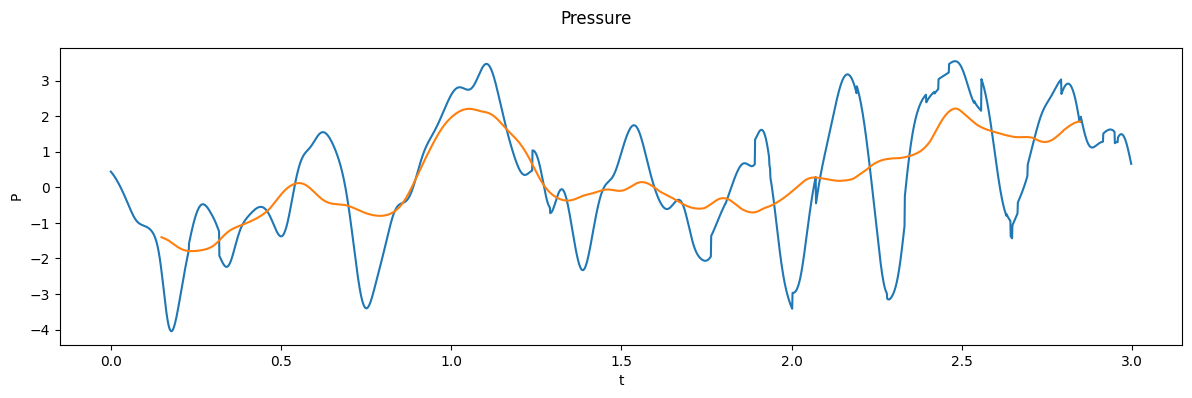

In [188]:
def window(size):
    return np.ones(size)/float(size)
WLEN = steps//10

fig,ax = plt.subplots()

Ps_win = np.convolve(Ps, window(WLEN),'same')[WLEN//2:-WLEN//2]
ax.plot(t,Ps)
ax.plot(t[WLEN//2:-WLEN//2], Ps_win)
ax.set_ylabel("P")
ax.set_xlabel("t")

fig.suptitle("Pressure")
fig.subplots_adjust(top=0.90)
fig.set_size_inches(12,4)
fig.tight_layout(pad=1)
fig.show()

In [191]:
def do_sim(r,v,t,L,T_target=None, zeta=None, Q=None):
    global wrap, DIM, N
    t_total,dt = t,0.001 # oops! left this as t=3 by mistake
    steps = int(t_total//dt)
    system = time_evolution(r,v,wrap,L,DIM,N,steps,dt, T_target=T_target, zeta=zeta, Q=Q)
    return system

def do_sims_Ls(r,T_target, n_times, A_end, results):
    global L
    v0 = rng.normal(0, T_target**0.5, (DIM,N))
    ls = np.linspace(L*L,A_end,n_times+1)**.5
    # print(ls); return
    for i in range(n_times+1):
        equil = do_sim(r,v,1,ls[i],T_target=T_target, zeta=None, Q=0.2)
        system = do_sim(equil.rs[-1],equil.vs[-1], 15, ls[i], T_target=T_target, zeta=equil.zeta, Q=5)
        results.append(system)

temperatures = [0.2, 0.5, 1, 1.5]
all_results = [[] for _ in range(len(temperatures))]
threads = [None]*len(temperatures)

# do_sims_Ls(r0, 0.5, 3, L*L*0.1, all_results[0])
for i,T in enumerate(temperatures):
    threads[i] = threading.Thread(target=do_sims_Ls, args=(r0, T, 10, L*L*10, all_results[i]))
    threads[i].start()

for i in range(len(threads)):
    threads[i].join()
print("FINISHED", threads)

with open("results2.pkl","wb") as results_pickle:
    pickle.dump(all_results,results_pickle)

FINISHED [<Thread(Thread-20 (do_sims_Ls), stopped 11072)>, <Thread(Thread-21 (do_sims_Ls), stopped 34984)>, <Thread(Thread-22 (do_sims_Ls), stopped 26764)>, <Thread(Thread-23 (do_sims_Ls), stopped 8112)>]


0.2


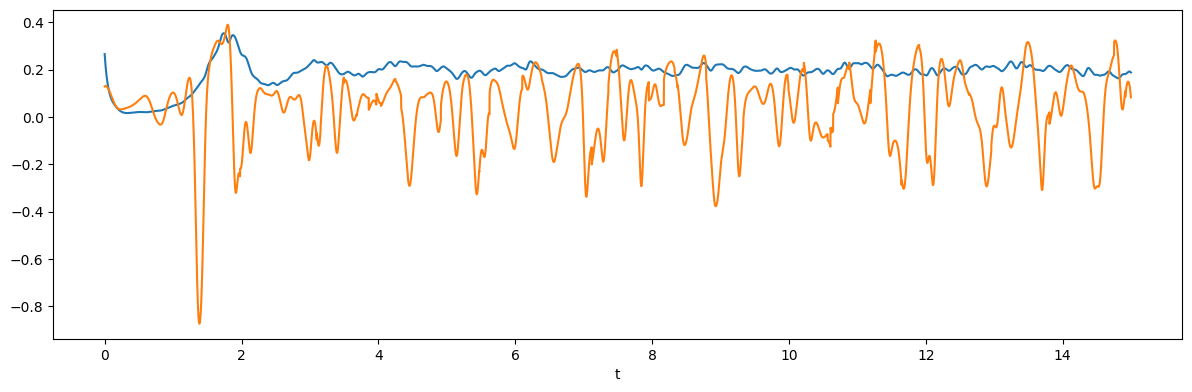

In [196]:
all_Ps = [[system.Ps for system in systemT] for systemT in all_results]

t_total,dt = 15,0.001
steps = int(t_total//dt)
t = np.arange(steps)*dt

print(all_results[0][4].T_target)

fig,ax = plt.subplots()
ax.plot(t,all_results[0][4].Ts)
ax.plot(t,all_Ps[0][4])
# ax.plot(t,all_Ps[-1][-1])
# ax.set_ylabel("P")
ax.set_xlabel("t")

# fig.suptitle("Pressure")
# fig.subplots_adjust(top=0.90)
fig.set_size_inches(12,4)
fig.tight_layout(pad=1)
fig.show()

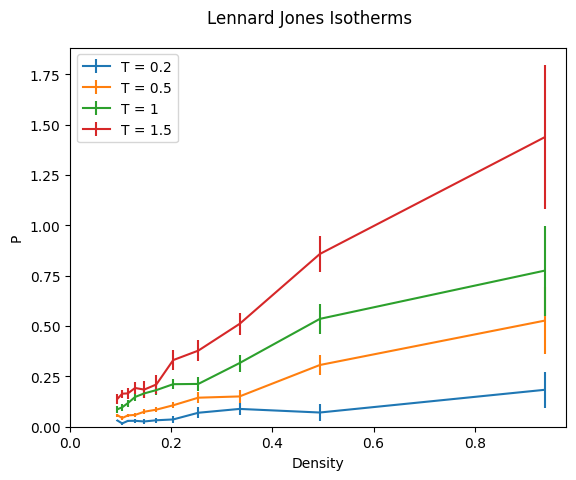

In [226]:
all_P_means = [[Ps[steps//3:].mean() for Ps in systemTPs] for systemTPs in all_Ps]
all_P_stds = [[Ps[steps//3:].std() for Ps in systemTPs] for systemTPs in all_Ps]

fig, ax = plt.subplots()


all_rhos = []
all_Pmeans = []
all_Pstds = []
for i, T in enumerate(temperatures):
    rhos = []
    Pmeans = []
    Pstds = []
    l = L
    for j in range(0,10+1):
        rhos.append(N/all_results[i][j].V)
        Pmeans.append(all_P_means[i][j])
        Pstds.append(all_P_stds[i][j])
        l += L*L*0.1 / l / 2
    rhos = np.array(rhos)
    Pmeans = np.array(Pmeans)
    Pstds = np.array(Pstds)
    ax.errorbar(rhos, Pmeans, 
        yerr=Pstds/(t_total*2/3), 
        label=f"T = {T}"
    )
    # ax.plot(rhos, Pmeans, label=f"T = {T}")
    all_rhos.append(rhos)
    all_Pmeans.append(Pmeans)
    all_Pstds.append(Pstds)


ax.set_ylabel("P")
ax.set_xlabel("Density")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

fig.suptitle("Lennard Jones Isotherms")
fig.subplots_adjust(top=0.90)
fig.savefig("Lennard Jones Isotherms.png")

# fig, ax = plt.subplots()
# nm = 1e-9
# k = scipy.constants.k
# epsilon = k*120
# sigma = 0.34 * nm
# # m = 39.948 * scipy.constants.u

# for i, T in enumerate(temperatures):
#     rhos = all_rhos[i]
#     Pmeans = all_Pmeans[i]
#     Pstds = all_Pstds[i]
#     ax.errorbar(
#         rhos / sigma**2 * nm**2,
#         Pmeans * (epsilon * sigma**-4), 
#         yerr=Pstds/(t_total*2/3) * (epsilon * sigma**-4), 
#         label=f"T = {T}"
#     )
#     # ax.plot(rhos, Pmeans, label=f"T = {T}")
# ax.set_ylabel("P")
# ax.set_xlabel("rho")
# ax.set_xlim(0)
# ax.set_ylim(0)
# ax.legend()

# fig.suptitle("Argon Isotherms")
# fig.subplots_adjust(top=0.90)
# fig.savefig("Argon Isotherms.png")

In [ ]:
for i,systemsT in enumerate(all_results):
    c = chr(ord('A')+i)
    for j,system in enumerate(systemsT):
        animate_system(system, f"gifs/T{c}{j}.gif")

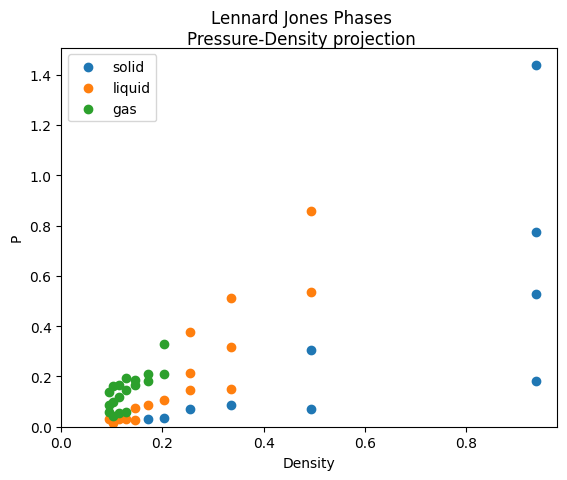

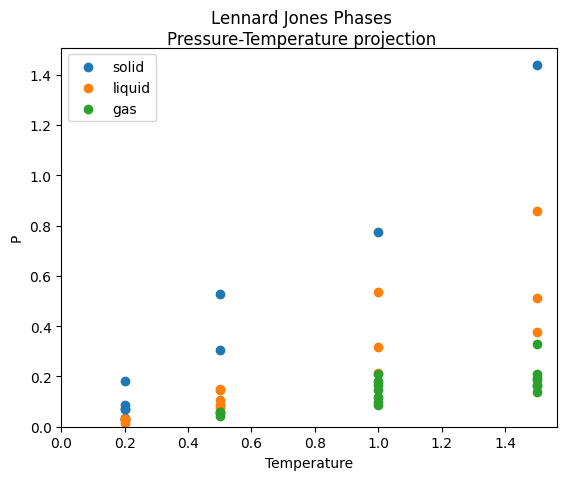

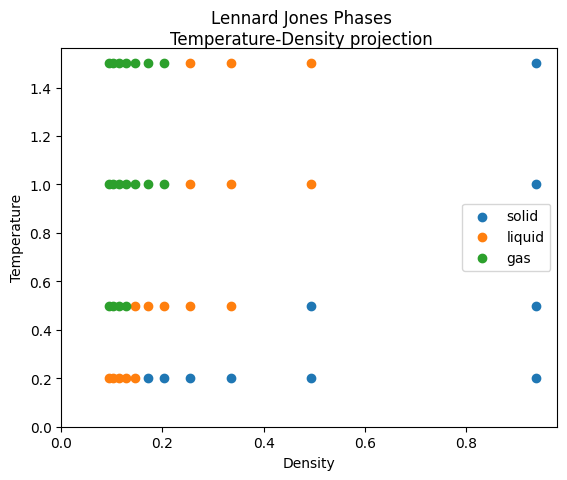

In [224]:
phases = [
    ["s", "s", "s", "s", "s", "s", "l", "l", "l", "l", "l"],
    ["s", "s", "l", "l", "l", "l", "l", "g", "g", "g", "g"],
    ["s", "l", "l", "l", "g", "g", "g", "g", "g", "g", "g"],
    ["s", "l", "l", "l", "g", "g", "g", "g", "g", "g", "g"],
]
fig, ax = plt.subplots()
def plot_phase_P_rho(ax,phase,label):
    ax.scatter(
        [rho for i,rhos in enumerate(all_rhos) for j,rho in enumerate(rhos) if phases[i][j]==phase],
        [P for i,Ps in enumerate(all_Pmeans) for j,P in enumerate(Ps) if phases[i][j]==phase],
        label=label
    )
plot_phase_P_rho(ax,"s","solid")
plot_phase_P_rho(ax,"l","liquid")
plot_phase_P_rho(ax,"g","gas")
ax.set_ylabel("P")
ax.set_xlabel("Density")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

fig.suptitle("Lennard Jones Phases\nPressure-Density projection")
fig.subplots_adjust(top=0.90)
fig.savefig("Phases P rho.png")

fig, ax = plt.subplots()
def plot_phase_P_T(ax,phase,label):
    ax.scatter(
        [temperatures[i] for i,Ps in enumerate(all_Pmeans) for j,P in enumerate(Ps) if phases[i][j]==phase],
        [P for i,Ps in enumerate(all_Pmeans) for j,P in enumerate(Ps) if phases[i][j]==phase],
        label=label
    )
plot_phase_P_T(ax,"s","solid")
plot_phase_P_T(ax,"l","liquid")
plot_phase_P_T(ax,"g","gas")
ax.set_ylabel("P")
ax.set_xlabel("Temperature")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

fig.suptitle("Lennard Jones Phases\nPressure-Temperature projection")
fig.subplots_adjust(top=0.90)
fig.savefig("Phases P T.png")

fig, ax = plt.subplots()
def plot_phase_T_rho(ax,phase,label):
    ax.scatter(
        [rho for i,rhos in enumerate(all_rhos) for j,rho in enumerate(rhos) if phases[i][j]==phase],
        [temperatures[i] for i,Ps in enumerate(all_Pmeans) for j,P in enumerate(Ps) if phases[i][j]==phase],
        label=label
    )
plot_phase_T_rho(ax,"s","solid")
plot_phase_T_rho(ax,"l","liquid")
plot_phase_T_rho(ax,"g","gas")
ax.set_ylabel("Temperature")
ax.set_xlabel("Density")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

fig.suptitle("Lennard Jones Phases\nTemperature-Density projection")
fig.subplots_adjust(top=0.90)
fig.savefig("Phases T rho.png")

In [405]:
# with open("systems.pkl","wb") as systems_pickle:
#     pickle.dump(system_saves,systems_pickle)